In [38]:
import os
import pandas as pd


# Specify the path to Excel results file
folder = '240115_CdD_M0'
file = 'results_2024-01-16.xlsx'

# create calibrations folder
directory_path = os.path.join(folder,'calibration')

if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created.")
else:
    print(f"Directory '{directory_path}' already exists.")

sheets_and_columns = {'15N': 'Delta_Value_vs_Reference_Material', '17O': 'Delta_Value_vs_Reference_Material', '18O': 'Delta_Value_vs_Reference_Material'}

df = pd.read_excel(os.path.join(folder,file), usecols=['sample.name'])

# Loop through each sheet and read the specified column into a DataFrame
for sheet_name, column_name in sheets_and_columns.items():
    df[''.join(['d',sheet_name])] = pd.read_excel(os.path.join(folder,file), sheet_name=sheet_name, usecols=[column_name])

df = df.dropna()

# remove last injections when was empty
df = df[df.index<232]

# seperate standards and samples
stds_df = df[df['sample.name'].str.startswith(('NICO','USGS')) ]
samples_df = df[df['sample.name'].str.startswith(('CdD', 'CDD')) ].sort_values(by='sample.name')

# function to average repeat injections of same sample
def summarise(df):

    isotopologs=['d15N','d17O','d18O']
    means=['mean_d15N','mean_d17O','mean_d18O']
    sems=['err_d15N','err_d17O','err_d18O']

    stats=pd.DataFrame()
    stats['sample.name']=df.groupby('sample.name')[isotopologs].mean().reset_index()['sample.name']
    stats[means]=df.groupby('sample.name')[isotopologs].mean().reset_index()[isotopologs]
    stats[sems]=df.groupby('sample.name')[isotopologs].sem().reset_index()[isotopologs]
    
    return stats.sort_values(by='sample.name')

# Contain mean and sem deltas of each sample
stds_stats = summarise(stds_df)
samples_stats = summarise(samples_df)

# Reference delta values and errors for calibration
references = pd.read_excel('references_nitrate.xlsx')
refs_stats = references[references['sample.name'].isin(stds_stats['sample.name'])].sort_values(by='sample.name')

Directory '240115_CdD_M0/calibration' already exists.


In [39]:
stds_stats.head()

,sample.name,mean_d15N,mean_d17O,mean_d18O,err_d15N,err_d17O,err_d18O
0,NICO6,40.756604,29.246506,39.003852,0.518050,1.280277,0.266658
1,USGS34,3.303020,-6.846158,-22.486818,0.272183,0.975377,0.404944
2,USGS35,7.436561,61.593503,62.562102,0.367473,0.580986,0.342715


In [40]:
refs_stats.head()

,sample.name,mean_d15N,mean_d17O,mean_d18O,mean_15N18O,mean_18O18O,mean_17O18O,err_d15N,err_d17O,err_d18O,err_15N18O,err_18O18O,err_17O18O
8,NICO6,33.7,NaN,32.87,0,0,0,0.3,NaN,0.3,0,0,0
0,USGS34,-1.8,-14.8,-27.90,0,0,0,0.3,0.3,0.3,0,0,0
1,USGS35,2.7,51.5,57.50,0,0,0,0.3,0.3,0.3,0,0,0


In [68]:
samples_stats.head(20)

,sample.name,mean_d15N,mean_d17O,mean_d18O,err_d15N,err_d17O,err_d18O
0,CDD-39,-0.072302,33.545327,42.013206,0.431652,1.061317,0.739681
1,CDD-40,-0.546760,34.093248,44.197479,0.714097,1.065609,0.429515
2,CDD-41,0.248259,40.557756,48.243491,0.745479,0.827907,0.624376
3,CDD-42,-1.955905,47.546581,53.944083,0.585242,1.008200,0.505251
4,CDD-43,-3.606685,54.827100,61.936994,0.536300,0.980370,0.413581
5,CDD-44,-2.104376,39.633299,48.961867,0.445181,1.445517,0.633706
6,CDD-45,-3.449142,49.576881,56.441772,0.635068,0.917760,0.423115
7,CDD-46,-5.347688,54.071902,58.751045,0.607807,0.969375,0.447682
8,CDD-47,-2.342630,59.647155,64.496191,0.551159,1.135101,0.520428
9,CDD-50,-1.459171,55.421862,61.770091,0.571331,1.289196,0.526195


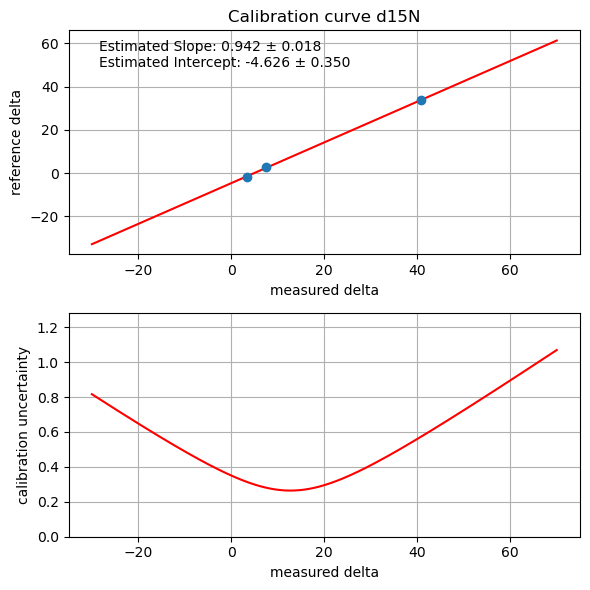

<Figure size 640x480 with 0 Axes>

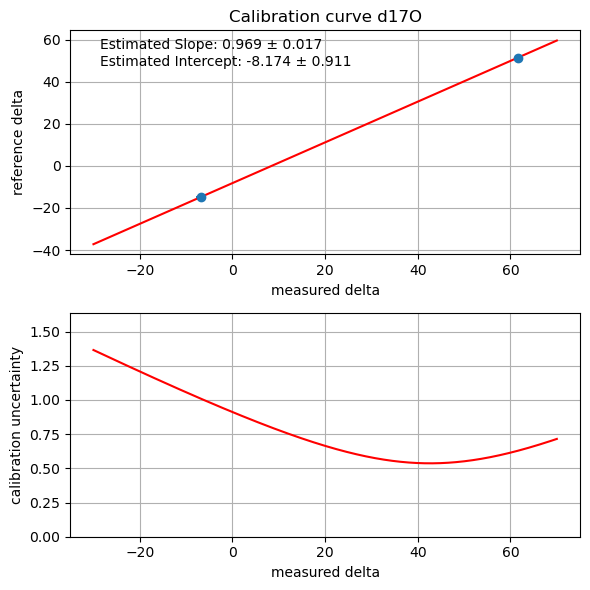

<Figure size 640x480 with 0 Axes>

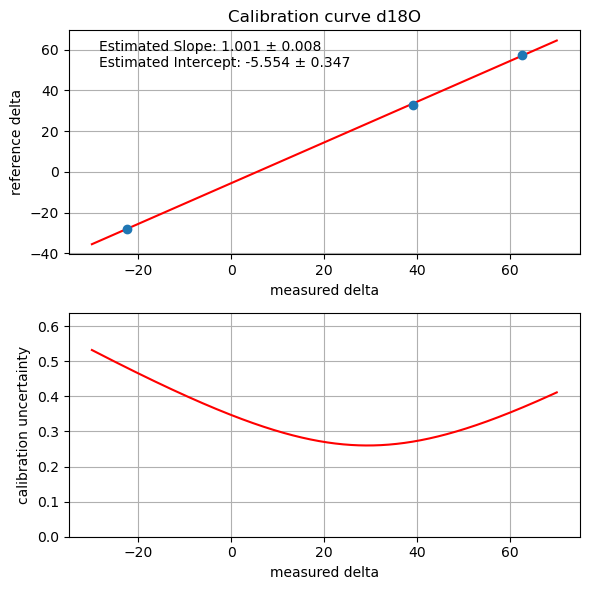

<Figure size 640x480 with 0 Axes>

In [41]:
# Linear calibration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime
current_datetime = datetime.now()
current_date_string = current_datetime.strftime("%Y-%m-%d")

# Number of iterations for perturbation
num_iterations = 5000
#  delta points to calculate calibration at
n_points = 1000
delta_range = [-30,70]
delta_meas=np.linspace(delta_range[0],delta_range[1],n_points)


# Create a DF with calibrations for all isotopes
isotopelist=['15N','17O','18O']
calibrations = pd.DataFrame(columns=['delta_meas','d15N_true','d17O_true','d18O_true','d15N_err','d17O_err','d18O_err'],index=range(n_points))
calibrations['delta_meas'] = delta_meas

for isotope in isotopelist:

    xx = stds_stats.reset_index()['mean_d'+isotope][refs_stats.reset_index()['mean_d'+isotope].notna()]
    dx = stds_stats.reset_index()['err_d'+isotope][refs_stats.reset_index()['mean_d'+isotope].notna()]
    yy= refs_stats.reset_index()['mean_d'+isotope][refs_stats.reset_index()['mean_d'+isotope].notna()]
    dy = refs_stats.reset_index()['err_d'+isotope][refs_stats.reset_index()['mean_d'+isotope].notna()]

    # Lists to store the results of each iteration
    slope_values = []
    intercept_values = []
    calib_values = np.zeros([n_points, num_iterations])

#   Peturb deltas by their uncertainty 
    for n in range(num_iterations):
        # Perturb x and y based on their Gaussian uncertainties
        perturbed_y = np.random.normal(yy, dy)
        perturbed_x = np.random.normal(xx, dx)

        # Perform linear regression on the perturbed data
        model = LinearRegression()
        model.fit(perturbed_x.reshape(-1, 1), perturbed_y)

        # Get the slope and intercept of the regression line for the perturbed data
        slope_values.append(model.coef_[0])
        intercept_values.append(model.intercept_)

        calib_values[:,n] = model.predict(delta_meas.reshape(-1, 1))

    # Calculate and save calibration stats
    calib_values = pd.DataFrame(calib_values)
    delta_true_mean = calib_values.mean(axis=1)
    delta_true_err = calib_values.std(axis=1)
    calibrations['d'+isotope+'_true'] = delta_true_mean
    calibrations['d'+isotope+'_err'] = delta_true_err
    

    # Calculate the mean and standard deviation of the obtained slope and intercept values
    mean_slope = np.mean(slope_values)
    std_slope = np.std(slope_values)
    mean_intercept = np.mean(intercept_values)
    std_intercept = np.std(intercept_values)

    # Plot the calibration curve and distribution of slope and intercept values
    plt.figure(figsize=(6,6))

    plt.subplot(2,1,1)
    plt.errorbar(xx,yy,
                 xerr=dx, yerr=dy,
                 fmt='o', label='Data Points')
    plt.plot(delta_meas, delta_true_mean, color='red', label='Weighted Linear Regression')
    plt.xlabel('measured delta')
    plt.ylabel('reference delta')
    plt.title('Calibration curve d'+isotope)
    plt.text(0.95*np.min(delta_meas),0.8*np.max(delta_true_mean), f"Estimated Slope: {mean_slope:.3f} ± {std_slope:.3f}\nEstimated Intercept: {mean_intercept:.3f} ± {std_intercept:.3f}")
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(delta_meas, delta_true_err, color='red', label='Uncertainty')
    plt.xlabel('measured delta')
    plt.ylabel('calibration uncertainty')
    plt.ylim([0,1.2*np.max(delta_true_err)])
    plt.grid()

    plt.tight_layout()
    plt.show();

    plt.savefig(os.path.join(folder,'calibration','_'.join(['calibration_curve',isotope,current_date_string,'.png'])));
    
# EXPORT
calibrations.to_csv(os.path.join(folder,'calibration',''.join(['calibration',current_date_string,'.csv'])))

    
    

In [42]:
#  CORRECTION of deltas using calibration

samples_corrected = samples_stats

for isotope in isotopelist:
    
    delta_corrected = np.interp(samples_stats['mean_d'+isotope],calibrations['delta_meas'],calibrations['d'+isotope+'_true'])
    calib_err = np.interp(samples_stats['mean_d'+isotope],calibrations['delta_meas'],calibrations['d'+isotope+'_err'])
    err_corrected = np.sqrt( samples_stats['err_d'+isotope]**2 + calib_err**2)
    
    samples_corrected['mean_d'+isotope] = delta_corrected
    samples_corrected['err_d'+isotope]=err_corrected
    
# EXPORT
samples_corrected.to_csv(os.path.join(folder,''.join(['calibrated_results',current_date_string,'.csv'])))

In [43]:
samples_corrected

,sample.name,mean_d15N,mean_d17O,mean_d18O,err_d15N,err_d17O,err_d18O
0,CDD-39,-0.072302,33.545327,42.013206,0.431652,1.061317,0.739681
1,CDD-40,-0.546760,34.093248,44.197479,0.714097,1.065609,0.429515
2,CDD-41,0.248259,40.557756,48.243491,0.745479,0.827907,0.624376
3,CDD-42,-1.955905,47.546581,53.944083,0.585242,1.008200,0.505251
4,CDD-43,-3.606685,54.827100,61.936994,0.536300,0.980370,0.413581
5,CDD-44,-2.104376,39.633299,48.961867,0.445181,1.445517,0.633706
6,CDD-45,-3.449142,49.576881,56.441772,0.635068,0.917760,0.423115
7,CDD-46,-5.347688,54.071902,58.751045,0.607807,0.969375,0.447682
8,CDD-47,-2.342630,59.647155,64.496191,0.551159,1.135101,0.520428
9,CDD-50,-1.459171,55.421862,61.770091,0.571331,1.289196,0.526195


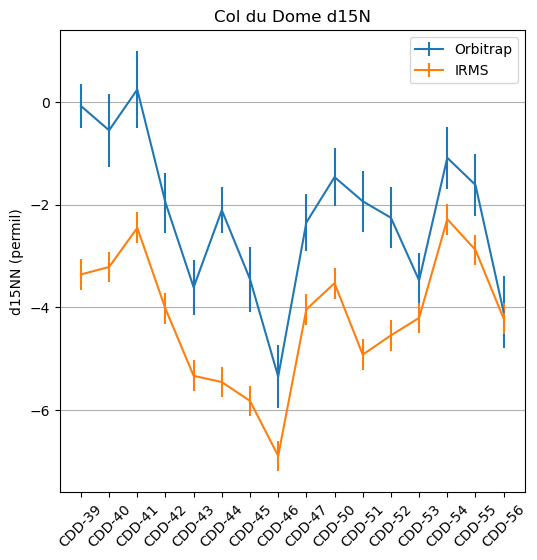

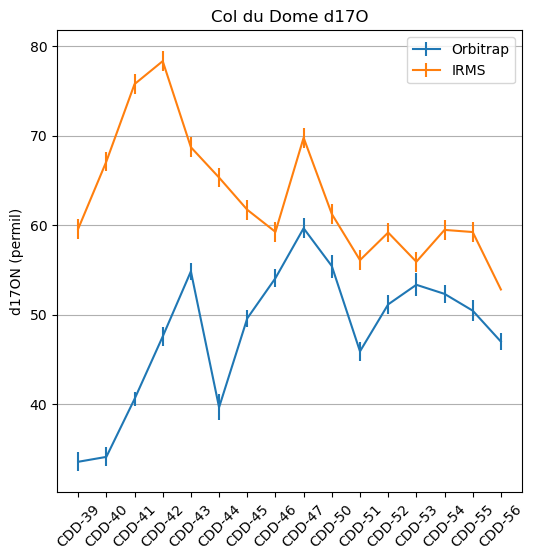

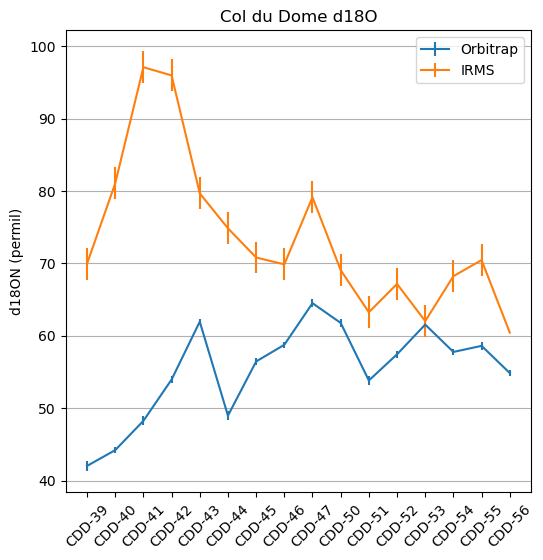

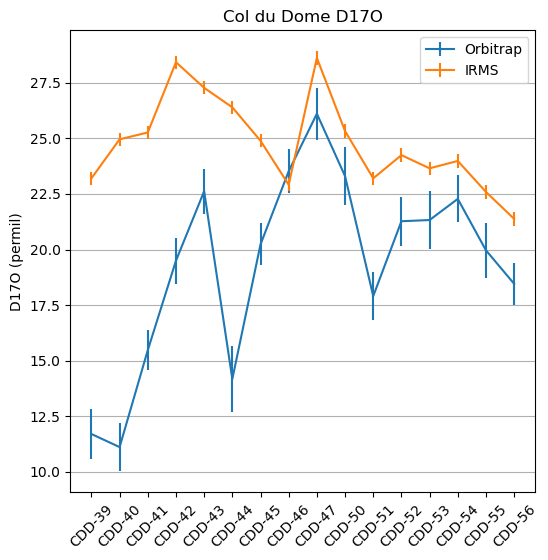

In [67]:
IRMS = pd.read_excel('CDD-IRMS.xlsx')
IRMS['sample.name']=samples_corrected['sample.name']

isotopes = ['15N','17O','18O']

for isotope in isotopes:
    
    plt.figure(figsize=[6,6])
    plt.errorbar(samples_corrected['sample.name'],samples_corrected['mean_d'+isotope],yerr=samples_corrected['err_d'+isotope],label='Orbitrap')
    plt.errorbar(IRMS['sample.name'],IRMS['d'+isotope+'_IRMS'],yerr=IRMS['d'+isotope+'_err'],label='IRMS')

    plt.ylabel('d'+isotope+'N (permil)')
    plt.xticks(rotation=45);
    plt.title('Col du Dome d'+isotope)
    plt.legend()
    plt.grid(axis='y')

D17O_orbitrap = samples_corrected['mean_d17O']-0.52*samples_corrected['mean_d18O']
D17O_orbitrap_err = np.sqrt( samples_corrected['err_d17O']**2 + (0.52 * samples_corrected['err_d18O'])**2 )
D17O_IRMS = IRMS['d17O_IRMS']-0.52*IRMS['d18O_IRMS']
D17O_IRMS_err = 0.3

plt.figure(figsize=[6,6])
plt.errorbar(samples_corrected['sample.name'],D17O_orbitrap,yerr=D17O_orbitrap_err,label='Orbitrap')
plt.errorbar(IRMS['sample.name'],D17O_IRMS,yerr=D17O_IRMS_err,label='IRMS')

plt.ylabel('D17O (permil)')
plt.xticks(rotation=45);
plt.title('Col du Dome D17O')
plt.legend()
plt.grid(axis='y')

In [51]:
IRMS

,sample.name,d15N_IRMS,d17O_IRMS,d180_IRMS,d15N_err,d17O_err,d18O_err
0,CDD-39,-3.357313,59.579905,69.954592,0.3,1.1,2.2
1,CDD-40,-3.210870,67.104953,81.053607,0.3,1.1,2.2
2,CDD-41,-2.448936,75.755453,97.096785,0.3,1.1,2.2
3,CDD-42,-4.024683,78.327159,95.962091,0.3,1.1,2.2
4,CDD-43,-5.333359,68.704524,79.673908,0.3,1.1,2.2
5,CDD-44,-5.454259,65.313050,74.838913,0.3,1.1,2.2
6,CDD-45,-5.821985,61.713816,70.806782,0.3,1.1,2.2
7,CDD-46,-6.894199,59.241000,69.859591,0.3,1.1,2.2
8,CDD-47,-4.037457,69.766146,79.130432,0.3,1.1,2.2
9,CDD-50,-3.526832,61.244474,69.067026,0.3,1.1,2.2
